# Classification with Decision Trees and Random Forests

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from classification_utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
import statistics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
import pickle

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
# data = data.join(pd.get_dummies(data["lang"]))

In [4]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


## Decision trees

In [6]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'ccp_alpha': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'max_depth' : np.arange(8, 25, 1),
              'criterion' :['gini', 'entropy']
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)


grid.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 5 folds for each of 612 candidates, totalling 3060 fits
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=log2;, score=0.857 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=log2;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=lo

[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=15, max_features=log2;, score=0.757 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=15, max_features=log2;, score=0.868 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=15, max_features=log2;, score=0.742 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=16, max_features=sqrt;, score=0.770 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=16, max_features=sqrt;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=16, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=16, max_features=sqrt;, score=0.849 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=16, max_features=sqrt;, score=0.742 total time=   0.0s
[CV 1/5] END ccp_al

[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=sqrt;, score=0.857 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=sqrt;, score=0.868 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=sqrt;, score=0.769 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.742 total time=   0.0s
[CV 1/5] END ccp_al

[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.769 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=log2;, score=0.695 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=log2;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=log2;, score=0.751 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=15, max_features=log2;, score=0.741 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=16, max_features=sqrt;, score=0.750 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=16, max_features=sqrt;, score=0.839 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=16, max_features=sqrt;, score=0.783 total time=

[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.786 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=log2;, score=0.857 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=log2;, score=0.842 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=log2;, score=0.765 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=23, max_features=log2;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.680 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.705 total time=

[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=14, max_features=log2;, score=0.852 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=14, max_features=log2;, score=0.742 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=sqrt;, score=0.754 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=sqrt;, score=0.680 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=sqrt;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=log2;, score=0.736 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=15, max_features=log2;, score=0.896 total time=   0.0s
[CV 3/5] E

[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=22, max_features=log2;, score=0.770 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=22, max_features=log2;, score=0.857 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=22, max_features=log2;, score=0.679 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=22, max_features=log2;, score=0.773 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=22, max_features=log2;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=23, max_features=sqrt;, score=0.772 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=23, max_features=sqrt;, score=0.697 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=23, max_features=sqrt;, score=0.679 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=23, max_features=sqrt;, score=0.746 total time=   0.0s
[CV 5/5] E

[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.845 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.826 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.722 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.741 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=log2;, score=0.857 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=log2;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=log2;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=14, max_features=log2;, score=0.832 to

[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.684 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.830 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=log2;, score=0.771 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=log2;, score=0.896 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=log2;, score=0.819 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=log2;, score=0.770 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=22, max_features=log2;, score=0.831 to

[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=12, max_features=log2;, score=0.859 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.842 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.857 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.773 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.774 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.898 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.801 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.878 total time=   0.0s
[CV 4/5] E

[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=20, max_features=log2;, score=0.769 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=sqrt;, score=0.812 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=sqrt;, score=0.844 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=sqrt;, score=0.868 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=sqrt;, score=0.769 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=log2;, score=0.781 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=log2;, score=0.826 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=21, max_features=log2;, score=0.867 total time=   0.0s
[CV 4/5] E

[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=11, max_features=log2;, score=0.853 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=11, max_features=log2;, score=0.881 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=sqrt;, score=0.833 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=sqrt;, score=0.874 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=sqrt;, score=0.810 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=sqrt;, score=0.898 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=sqrt;, score=0.852 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=log2;, score=0.894 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=12, max_features=log2;, score=0.894 to

[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.853 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.880 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.854 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.831 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=log2;, score=0.836 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=log2;, score=0.888 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=log2;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=log2;, score=0.875 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=19, max_features=log2;, score=0.886 to

[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=sqrt;, score=0.879 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=sqrt;, score=0.892 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=log2;, score=0.793 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=log2;, score=0.861 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=log2;, score=0.883 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=log2;, score=0.863 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=10, max_features=log2;, score=0.845 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=11, max_features=sqrt;, score=0.879 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=11, max_features=sqrt;, score=0.872 total time=   0.0s
[

[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=18, max_features=log2;, score=0.881 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=18, max_features=log2;, score=0.840 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=18, max_features=log2;, score=0.789 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=18, max_features=log2;, score=0.853 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=19, max_features=sqrt;, score=0.881 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=19, max_features=sqrt;, score=0.841 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=19, max_features=sqrt;, score=0.878 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=19, max_features=sqrt;, score=0.898 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=19, max_features=sqrt;, score=0.859 total time=   0.0s
[

[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=9, max_features=log2;, score=0.894 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=9, max_features=log2;, score=0.824 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=9, max_features=log2;, score=0.808 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=9, max_features=log2;, score=0.879 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.893 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.868 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.818 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.900 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.8

[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=16, max_features=log2;, score=0.883 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=16, max_features=log2;, score=0.875 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.837 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.842 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.867 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.889 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=log2;, score=0.880 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=17, max_features=log2;, score

[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.866 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.886 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.854 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.886 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.818 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=log2;, score=0.833 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=log2;, score=0.881 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=log2;, score=0.870 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=24, max_features=log2;, score

[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.884 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.868 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.895 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.896 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=log2;, score=0.861 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=log2;, score=0.850 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=log2;, score=0.865 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=log2;, score=0.844 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=15, max_features=log2;, score=0.858 total time=   0.0s
[

[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=22, max_features=log2;, score=0.871 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=22, max_features=log2;, score=0.882 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=22, max_features=log2;, score=0.874 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=sqrt;, score=0.866 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=sqrt;, score=0.899 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=sqrt;, score=0.845 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=sqrt;, score=0.836 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=sqrt;, score=0.895 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=23, max_features=log2;, score=0.891 total time=   0.0s
[

[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=13, max_features=log2;, score=0.884 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.885 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.859 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.879 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.888 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.891 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.874 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score

[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=21, max_features=log2;, score=0.867 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=21, max_features=log2;, score=0.834 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.889 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.873 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.877 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.862 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=log2;, score=0.874 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=22, max_features=log2;, score

[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=12, max_features=log2;, score=0.800 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=12, max_features=log2;, score=0.896 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=12, max_features=log2;, score=0.875 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=sqrt;, score=0.888 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=sqrt;, score=0.879 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=sqrt;, score=0.889 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=13, max_features=log2;, score=0.896 total time=

[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=sqrt;, score=0.895 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=log2;, score=0.886 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=log2;, score=0.886 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=log2;, score=0.840 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=log2;, score=0.894 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=log2;, score=0.883 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=21, max_features=sqrt;, score=0.893 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=21, max_features=sqrt;, score=0.875 total time=

[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=sqrt;, score=0.894 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=sqrt;, score=0.880 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=sqrt;, score=0.898 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=sqrt;, score=0.867 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=log2;, score=0.875 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=log2;, score=0.874 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=log2;, score=0.878 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=log2;, score=0.899 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=11, max_features=log

[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=18, max_features=log2;, score=0.869 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=18, max_features=log2;, score=0.843 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.867 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.853 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.849 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.872 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=log2;, score=0.868 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=19, max_features=log

[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.855 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.829 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.866 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=log2;, score=0.861 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=log2;, score=0.848 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=log2;, score=0.862 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=log2;, score=0.828 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=10, max_features=log2;, score=0.835 total time=

[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=sqrt;, score=0.851 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=log2;, score=0.877 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=log2;, score=0.862 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=log2;, score=0.859 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=log2;, score=0.840 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=18, max_features=log2;, score=0.849 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=19, max_features=sqrt;, score=0.862 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=19, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=19, max_features=sqrt;, score=0.847 total time=

[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=8, max_features=log2;, score=0.807 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=8, max_features=log2;, score=0.851 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.857 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.876 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.871 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.849 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=log2;, score=0.832 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=log2;, score

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=16, max_features=log2;, score=0.868 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.873 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.853 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.873 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=log2;, score=0.878 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=log2;, score=0.863 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=17, max_features=log

[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.842 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=log2;, score=0.841 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=log2;, score=0.839 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=log2;, score=0.847 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=log2;, score=0.857 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=24, max_features=log2;, score=0.860 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=8, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=8, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=8, max_features=sqrt;, score=0.531 total

[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=16, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_al

[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=23, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=23, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=23, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=23, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=23, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=24, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=24, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=24, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=24, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_al

[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.531 total time=

[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=22, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.531 total time=

[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=13, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=13, max_features=log2;, score=0.868 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=13, max_features=log2;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=14, max_features=log2;, score=0.857 total time=   0.0s
[CV 2/5] END ccp_al

[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=21, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=21, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=sqrt;, score=0.868 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=log2;, score=0.532 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=22, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_al

[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=12, max_features=log2;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.770 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.741 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=log2;, score=0.750 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=log2;, score=0.760 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=13, max_features=log2;, score=0.765 total time=

[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.757 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=log2;, score=0.770 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=log2;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=log2;, score=0.770 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=21, max_features=log2;, score=0.741 total time=

In [7]:
dt = grid.best_estimator_

In [8]:
dt

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='log2')

In [9]:
train_pred = dt.predict(train_set)
test_pred = dt.predict(test_set)

In [10]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8657976412166356
Accuracy test set  0.8447726614538082
Precision train set  0.8873794708928441
Recall train set  0.8657976412166356
F1 score train set  0.8626825663219935
Support train set  (array([0.98175313, 0.80418251]), array([0.72708002, 0.9880869 ]), array([0.83543918, 0.88669951]), array([3774, 4281]))


In [11]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.97      0.69      0.81      1618
         >50       0.78      0.98      0.87      1835

    accuracy                           0.84      3453
   macro avg       0.88      0.84      0.84      3453
weighted avg       0.87      0.84      0.84      3453



In [12]:
# cross validation
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.014553308486938477
Score time  0.0027778148651123047
Test score  0.8677839851024208
Train score  0.8820608317815022


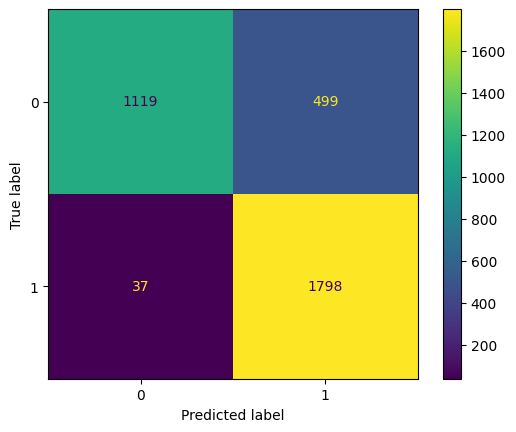

In [13]:
predictions = dt.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [14]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

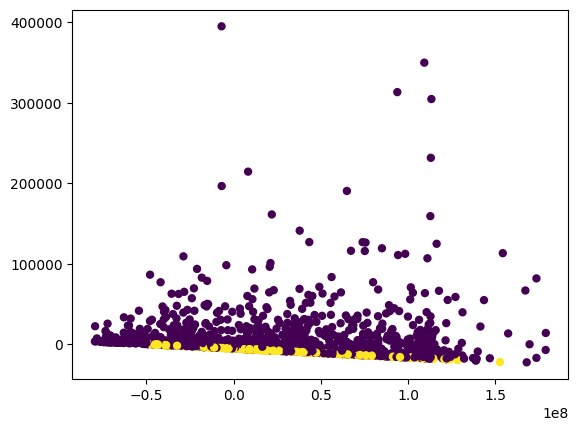

In [15]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

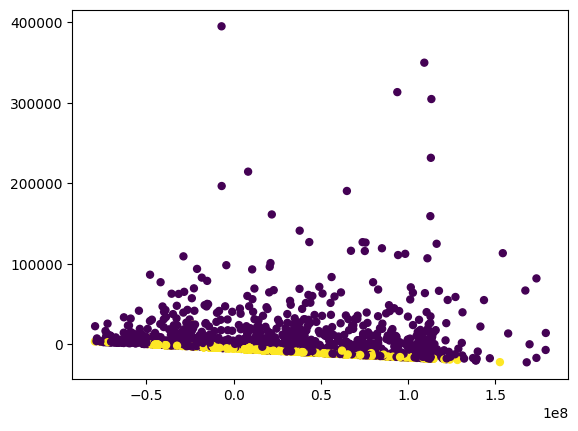

In [16]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save Model

In [ ]:
with open("models_checkpoints/decision_tree_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)

## Random forest

### Hyperparameter Grid Search

In [18]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_set, train_label)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [19]:
rf = grid_search.best_estimator_

In [20]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [21]:
# cross validation
scores = cross_validate(rf, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  12.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   3.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   4.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples

[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   3.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_sample

[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time=  13.9s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   3.4s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samp

KeyboardInterrupt: 

In [ ]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

In [ ]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

In [ ]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save Model

In [ ]:
with open("models_checkpoints/random_forest_1_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)

### Random Hyperparameter Grid Search

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=4,
    random_state=42,
    n_jobs = -1
)

rf_random.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (rf_random.best_params_, rf_random.best_score_)
)



In [ ]:
rf = rf_random.best_estimator_

In [ ]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [ ]:
# cross validation
scores = cross_validate(rf, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

In [ ]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [ ]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

In [ ]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

In [ ]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Save Model

In [ ]:
with open("models_checkpoints/random_forest_2_no_lang.bin", "wb") as f:
    pickle.dump(dt, f)